In [1]:
import pandas as pd
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib import cm
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

- which companies have the most applications for data scientists
- how do data scientist salaries compare to the rest of the applicants
- how do data scientst salaries compare to the the rest of the Data jobs
- has applicants for data scientist evolved over time
    - in absolute numbers
    - and in comparison to the market, i.e, percentage of jobs that are data related
- Location: Where are most data scientists located (Place and State)

In [2]:
df = pd.read_csv('./h1b_kaggle.csv', index_col=0)

/Users/dileepkini/miniconda3/envs/pt36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


### Data Preparation
- are there any null/nan values?
- should we restrict the applications to the ones that have been certified? 
- how do we identify data related jobs?
    - For the sake of simplicity we shall assume that any job title that contains 'data' as a substring is a data  job. What are the different forms in which the word "data" appears in a job title?
    - similarly we assume that any job title that contains 'data scien' to be a data scientist-ish jobs. This is a subset of data jobs.
- extract state from the location column

In [3]:
df.shape

(3002458, 10)

In [4]:
df.isnull().sum()

CASE_STATUS               13
EMPLOYER_NAME             59
SOC_NAME               17734
JOB_TITLE                 43
FULL_TIME_POSITION        15
PREVAILING_WAGE           85
YEAR                      13
WORKSITE                   0
lon                   107242
lat                   107242
dtype: int64

- As we can see above some of the columns contain null values. But we will not be dropping any data because we won't be applying any modeling to answer our questions.

Next we look to derive relevant information from the existing columns:
- Use the JOB_TITLE column to infer whether the job falls in the data domain, and more specifically if it is a data science position
- extract the State from the WORKSITE column
- figure out whether an application is certified or not from the CASE_STATUS columns

In [5]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

In [6]:
df['title'] = df['JOB_TITLE'].astype(str).str.lower().apply(lambda _: _.translate(translator))

In [7]:
df['is_data_related'] = df['title'].apply(lambda _: ('data' in _))
df['is_data_science'] = df['title'].apply(lambda _: ('data scien' in _))

In [8]:
df['state'] = df['WORKSITE'].str.split(', ').apply(lambda _: _[-1])

In [9]:
data_words = list([_ for lst in df[df.is_data_related]['title'].str.split().values for _ in lst if 'data' in _])

In [10]:
Counter(data_words).most_common(20)

[('database', 34873),
 ('data', 29870),
 ('datastage', 644),
 ('teradata', 492),
 ('datawarehouse', 354),
 ('datapower', 66),
 ('datawarehousing', 55),
 ('databases', 33),
 ('metadata', 29),
 ('databse', 27),
 ('datacenter', 23),
 ('dataware', 20),
 ('bigdata', 19),
 ('datasets', 9),
 ('aiddata', 8),
 ('medidata', 8),
 ('exadata', 8),
 ('teredata', 6),
 ('terradata', 5),
 ('datacom', 5)]

In [11]:
df['is_cert'] = df.CASE_STATUS.isin(['CERTIFIED', 'CERTIFIED-WITHDRAWN'])

- we only choose to retain those applications which are certified. Denied applications contain incorrect/missing information and are therefore rejected by USCIS

In [12]:
df = df[df.is_cert].copy()

### Number of jobs in the data domain.

In [13]:
df.is_data_related.value_counts()

False    2755513
True       62769
Name: is_data_related, dtype: int64

In [14]:
df.is_data_related.value_counts()/df.shape[0]

False   0.98
True    0.02
Name: is_data_related, dtype: float64

### Employers

In [15]:
data_employers = df[df.is_data_related].EMPLOYER_NAME.value_counts()
data_employers.sort_values(ascending=False)[:20]

TATA CONSULTANCY SERVICES LIMITED    3479
CAPGEMINI AMERICA INC                1043
WIPRO LIMITED                         965
IBM INDIA PRIVATE LIMITED             730
ECLINICALWORKS, LLC                   490
INFOLOB SOLUTIONS, INC.               445
FUJITSU AMERICA, INC.                 409
CAPITAL ONE SERVICES, LLC             390
AMAZON CORPORATE LLC                  374
SREE INFOTECH LLC                     352
TECH MAHINDRA (AMERICAS),INC.         339
TEK SERVICES LLC                      275
FACEBOOK, INC.                        269
LARSEN & TOUBRO INFOTECH LIMITED      251
MICROSOFT CORPORATION                 250
JPMORGAN CHASE & CO.                  234
ADS ALLIANCE DATA SYSTEMS, INC.       211
POPULUS GROUP                         207
SIRI INFOSOLUTIONS INC.               207
IGATE TECHNOLOGIES INC.               198
Name: EMPLOYER_NAME, dtype: int64

In [16]:
df.is_data_science.value_counts()

False    2814913
True        3369
Name: is_data_science, dtype: int64

#### What fraction of all data related applications is made up by data science positions?
- turns out 5% of all jobs in the data domain are

In [17]:
df[df.is_data_related].is_data_science.value_counts()/df.is_data_related.sum()

False   0.95
True    0.05
Name: is_data_science, dtype: float64

#### Which employers petition for the most data scientists?
- Some very large and well known tech companies

In [18]:
data_science_employers = df[df.is_data_science].EMPLOYER_NAME.value_counts()
data_science_employers.sort_values(ascending=False)[:20]

MICROSOFT CORPORATION            188
FACEBOOK, INC.                   119
LINKEDIN CORPORATION              90
UBER TECHNOLOGIES, INC.           57
TWITTER, INC.                     54
WAL-MART ASSOCIATES, INC.         46
NETFLIX, INC.                     34
GROUPON, INC.                     30
PAYPAL, INC.                      28
APPLE INC.                        26
IBM CORPORATION                   26
EMC CORPORATION                   23
AIRBNB, INC.                      23
CAPITAL ONE SERVICES, LLC         21
AGILONE, INC.                     19
GSR TECHNOLOGIES INC.             19
AIG PC GLOBAL SERVICES, INC.      17
THE NIELSEN COMPANY (US), LLC     16
MONSANTO COMPANY                  16
EBAY INC.                         16
Name: EMPLOYER_NAME, dtype: int64

#### Among companies that hire at least 100 data related jobs, what fraction of those are data scientists

In [19]:
data_employer_df = pd.concat([data_employers, data_science_employers], axis=1)
data_employer_df.columns = ['all_data','data_science']
data_employer_df = data_employer_df.fillna(0).astype(int)
data_employer_df['data_science_pct'] = data_employer_df['data_science'] * 100 / data_employer_df['all_data']

In [20]:
data_employer_df[(data_employer_df.all_data >= 100) & (data_employer_df.data_science > 0)].sort_values('data_science_pct', ascending=False)

,all_data,data_science,data_science_pct
MICROSOFT CORPORATION,250,188,75.20
LINKEDIN CORPORATION,160,90,56.25
"FACEBOOK, INC.",269,119,44.24
"PAYPAL, INC.",104,28,26.92
APPLE INC.,126,26,20.63
INTUIT INC.,124,12,9.68
"SALESFORCE.COM, INC.",101,9,8.91
"CAPITAL ONE, NATIONAL ASSOCIATION",138,11,7.97
ACCENTURE LLP,124,8,6.45
JPMORGAN CHASE & CO.,234,13,5.56


### Q: Have data science H-1B applications increased over time?
there are several subuestions here:
1. Have job applications in the data domain increased over time?
2. Have applicants in the data domain grown faster than the overall pool of H-1B applications?
3. Have visa applications for data science jobs increased over time?
4. Have the number of data science applications grown faster compared to the pool of data related applications?

In [21]:
data_by_year = df.groupby('YEAR').agg({'is_data_related':'sum', 'is_data_science':'sum', 'JOB_TITLE':'count'}).astype(int)
data_by_year.index = data_by_year.index.astype(int)
data_by_year = data_by_year.rename(columns={'JOB_TITLE':'total'})
data_by_year['data_science_pct'] = data_by_year['is_data_science']

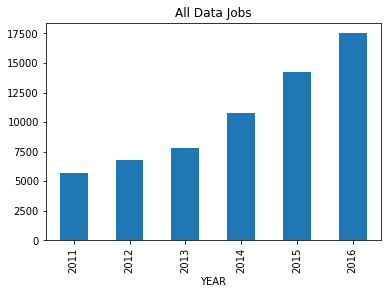

In [22]:
(data_by_year['is_data_related']).plot(kind='bar', title='All Data Jobs');

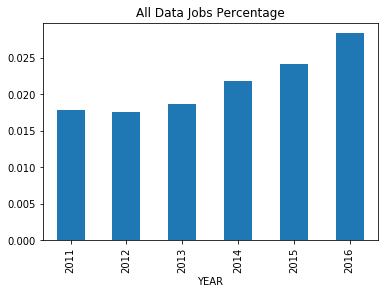

In [23]:
(data_by_year['is_data_related']/data_by_year['total']).plot(kind='bar', title='All Data Jobs Percentage');

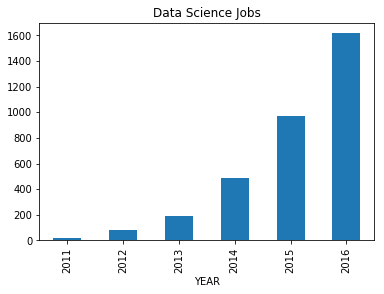

In [24]:
(data_by_year['is_data_science']).plot(kind='bar', title='Data Science Jobs');

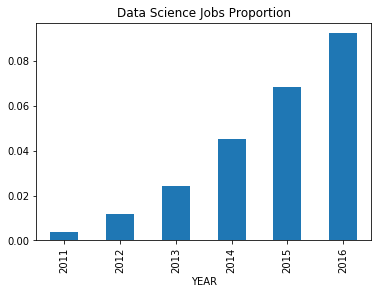

In [25]:
(data_by_year['is_data_science']/data_by_year['is_data_related']).plot(kind='bar', title='Data Science Jobs Proportion');

### Q: Where are the data jobs located?

In [26]:
data_by_loc = df.groupby('WORKSITE').agg({'is_data_related':'sum', 'is_data_science':'sum', 'JOB_TITLE':'count'}).astype(int)
data_by_loc = data_by_loc.rename(columns={'JOB_TITLE':'total'})

In [27]:
data_by_state = df.groupby('state').agg({'is_data_related':'sum', 'is_data_science':'sum', 'JOB_TITLE':'count'}).astype(int)
data_by_state = data_by_state.rename(columns={'JOB_TITLE':'total'})
data_by_state = data_by_state.sort_values('is_data_science', ascending=False)
data_by_state['cum_data_science'] = data_by_state['is_data_science'].cumsum()*100/data_by_state.is_data_science.sum()

In [28]:
data_by_state

,is_data_related,is_data_science,total,cum_data_science
state,,,,
CALIFORNIA,11963,1677,524924,49.78
NEW YORK,4540,378,269647,61.00
WASHINGTON,2246,249,98126,68.39
MASSACHUSETTS,3178,214,109403,74.74
ILLINOIS,3109,115,152290,78.15
TEXAS,5985,113,276825,81.51
NEW JERSEY,5277,86,202729,84.06
GEORGIA,2919,65,97272,85.99
VIRGINIA,2930,55,84665,87.62


- Looking at the data above it appears that California has almost 50% of all data science jobs, and the top 6 states (CA, NY, WA, MA, IL, TX) cover more than 80% of all data science jobs.
- Next we visualize this data on United States map

In [29]:
usa = gpd.read_file('./data/S/geo_export_147a1d75-342a-4acc-b46f-b93aaab27e22.shp')

DriverError: Unable to open ./geo_export_147a1d75-342a-4acc-b46f-b93aaab27e22.shx or ./geo_export_147a1d75-342a-4acc-b46f-b93aaab27e22.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [ ]:
state_pct_dict = {k.lower():v for (k,v) in ((100 - data_by_state.cum_data_science)/100).to_dict().items()}

usa['color'] = usa.state_name.str.lower().map(state_pct_dict).apply(lambda _: cm.Blues((_ + 0.3) if _ > 0 else 0))

In [ ]:
fig, ax = plt.subplots(figsize=(20,18))
for i, row in usa.iterrows():
    if row.state_abbr not in (['HI', 'AK']):
        usa[usa.state_abbr == row.state_abbr].plot(ax=ax, color=row.color, edgecolor='y')

### Q: Do data scientists get higher wages compared to general data jobs?
- we compare the prevailing wages for applications for all data jobs vs those for data science.
- Just by eyeballing the distributions one can tell that prevailing wages for data science job tends to be higher than those of general data jobs.
- Looking at the descriptive statistics we see that the mean and the median for data science jobs are > $20k higher than those for general data jobs.

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)
axs[0].set_title('Data Science')
axs[0].hist(df[df['is_data_science']].PREVAILING_WAGE.values, bins=30);
axs[1].set_title('All Data')
axs[1].hist(df[df['is_data_related']].PREVAILING_WAGE.values, bins=30);

In [ ]:
df[df['is_data_science']].PREVAILING_WAGE.describe()

In [ ]:
df[df['is_data_related']].PREVAILING_WAGE.describe()